# Project: Image Classification and Regression
## Mini Project No.1 - Deep Learning
### Author: Ana Montalvo

The goal of this project is to learn how to implement simple image classification and regression in Keras.

### Getting Started: Libraries and Generating Dataset Functions

In [1]:
# Libraries
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical

import  numpy as np
import  matplotlib.pyplot as plt

import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Functions for generating different images datasets:

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    from keras.utils.np_utils import to_categorical
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    #print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(15, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

### Simple Classification
Generating the dataset of triangles, rectangles and disks.

In [3]:
# Generate X_train and Y_train
[X_train,Y_train]=generate_dataset_classification(300,2);
predictors = X_train
target = to_categorical(Y_train)
print('X_train shape is : ',X_train.shape)
print('Y_train shape is : ',Y_train.shape)

# Build Model
n_cols=X_train.shape[1]
model = Sequential()
model.add(Dense(20,activation='relu',input_shape=(n_cols,)))
model.add(Dense(20,activation='relu'))
model.add(Dense(3,activation='softmax',input_shape=(n_cols,)))


X_train shape is :  (300, 5184)
Y_train shape is :  (300,)


#### Using Keras SGD (Stochastic Gradient Descent) optimizer

SGD Optimizer

300/300 [==============================] - 0s 441us/step
Train Loss :  0.0010924697007673482
Train Accuracy  1.0
Visualization of Solution



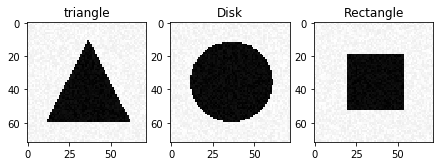

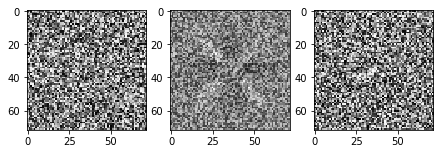

In [4]:
# Keras: stochastic gradient descent
print("SGD Optimizer")
print("")
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(predictors,target,epochs=300,batch_size=32,verbose=0)

#Model Evaluation on Training Set
loss, accuracy = model.evaluate(predictors, target)
print('Train Loss : ',loss)
print('Train Accuracy ',accuracy)

# Running it on test dataset
X_test, _ = generate_dataset_classification(3, 20)

X_test0 = X_test[0].reshape(1, X_test.shape[1])
X_test1 = X_test[1].reshape(1, X_test.shape[1])
X_test2 = X_test[2].reshape(1, X_test.shape[1])

Y_test0 = model.predict(X_test0)
Y_test1 = model.predict(X_test1)  
Y_test2 = model.predict(X_test2)


#Visualization of Solution
print("Visualization of Solution")
print("")

weights = model.get_weights()[0]
label = {0 : 'Rectangle' , 1:'Disk', 2:'triangle'}

plt.figure(figsize=((15,4)))
plt.subplot(1,6,1)
plt.imshow(X_test0.reshape((int(np.sqrt(X_test0.shape[1])),int(np.sqrt(X_test0.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test0)])
plt.subplot(1,6,2)
plt.imshow(X_test1.reshape((int(np.sqrt(X_test1.shape[1])), int(np.sqrt(X_test1.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test1)])
plt.subplot(1,6,3)
plt.imshow(X_test2.reshape((int(np.sqrt(X_test2.shape[1])),int(np.sqrt(X_test2.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test2)])
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1,6,1)
plt.imshow(weights[:,0].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.subplot(1,6,2)
plt.imshow(weights[:,1].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.subplot(1,6,3)
plt.imshow(weights[:,2].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.show()

#### Using Keras Adam optimizer

Adam Optimizer

300/300 [==============================] - 0s 567us/step
Train Loss :  1.1873682633449788e-05
Train Accuracy  1.0
Visualization of Solution



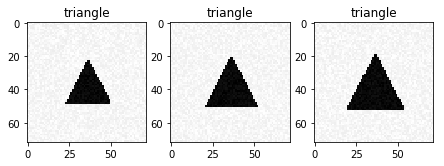

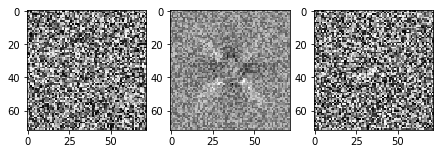

In [5]:
# Keras: Adam optimizer
print("Adam Optimizer")
print("")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(predictors,target,epochs=300,batch_size=32,verbose=0)

#Model Evaluation on Training Set
loss, accuracy = model.evaluate(predictors, target)
print('Train Loss : ',loss)
print('Train Accuracy ',accuracy)

# Running it on test dataset
X_test, _ = generate_dataset_classification(3, 20)

X_test0 = X_test[0].reshape(1, X_test.shape[1])
X_test1 = X_test[1].reshape(1, X_test.shape[1])
X_test2 = X_test[2].reshape(1, X_test.shape[1])

Y_test0 = model.predict(X_test0)
Y_test1 = model.predict(X_test1)  
Y_test2 = model.predict(X_test2)

#Visualization of Solution
print("Visualization of Solution")
print("")

weights = model.get_weights()[0]
label = {0 : 'Rectangle' , 1:'Disk', 2:'triangle'}

plt.figure(figsize=((15,4)))
plt.subplot(1,6,1)
plt.imshow(X_test0.reshape((int(np.sqrt(X_test0.shape[1])),int(np.sqrt(X_test0.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test0)])
plt.subplot(1,6,2)
plt.imshow(X_test1.reshape((int(np.sqrt(X_test1.shape[1])), int(np.sqrt(X_test1.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test1)])
plt.subplot(1,6,3)
plt.imshow(X_test2.reshape((int(np.sqrt(X_test2.shape[1])),int(np.sqrt(X_test2.shape[1])) )),cmap='gray')
plt.title(label[np.argmax(Y_test2)])
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1,6,1)
plt.imshow(weights[:,0].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.subplot(1,6,2)
plt.imshow(weights[:,1].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.subplot(1,6,3)
plt.imshow(weights[:,2].reshape(( int(np.sqrt(weights.shape[0])), int(np.sqrt(weights.shape[0])) )),cmap='gray')
plt.show()

### More Difficult Classification Problem
The shapes are allowed to move within the images and change dimensions.

In [6]:
# Generate X_train and Y_train
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y = to_categorical(Y_train)
[X_test, Y_test] = generate_test_set_classification()
X_test = X_test.reshape(-1,72,72,1)
print('X_train shape is : ',X_train.shape)
print('Y_train shape is : ',Y.shape)

X_train shape is :  (300, 5184)
Y_train shape is :  (300, 3)


In [7]:
# Convolution of the loss function in the test set
img = 72
model2 = Sequential()
model2.add(Conv2D(16, (5,5),input_shape=(img,img,1), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(32, (5,5), activation='relu'))
model2.add(MaxPooling2D(pool_size=(1, 1)))
model2.add(Flatten())
model2.add(Dense(3,activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train.reshape(-1,72,72,1), Y, epochs=100, batch_size=32,  verbose=0)

#Model Evaluation on Training Set
loss, accuracy = model2.evaluate(X_train.reshape(-1,72,72,1), Y)
print('Train Loss : ',loss)
print('Train Accuracy ',accuracy)

#Model Evaluation on Test Set
loss, accuracy = model2.evaluate(X_test, Y_test)
print('Test Loss : ',loss)
print('Test Accuracy ',accuracy)


300/300 [==============================] - 1s 5ms/step
Train Loss :  0.00035925669168742995
Train Accuracy  1.0
300/300 [==============================] - 1s 4ms/step
Test Loss :  1.300569594701131
Test Accuracy  0.7733333333333333


Visualization of Solution



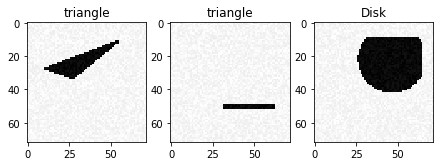

In [8]:
# Running it on test dataset
X_test, _ = generate_dataset_classification(3, 20, True)

X_test0 = X_test[0].reshape(1, img,img,1)
X_test1 = X_test[1].reshape(1, img,img,1)
X_test2 = X_test[2].reshape(1, img,img,1)

Y_test0 = model2.predict(X_test0)
Y_test1 = model2.predict(X_test1)  
Y_test2 = model2.predict(X_test2)

#Visualization of Solution
print("Visualization of Solution")
print("")

label = {0 : 'Rectangle' , 1:'Disk', 2:'triangle'}

plt.figure(figsize=((15,4)))
plt.subplot(1,6,1)
plt.imshow(X_test0.reshape(img,img),cmap='gray')
plt.title(label[np.argmax(Y_test0)])
plt.subplot(1,6,2)
plt.imshow(X_test1.reshape(img,img),cmap='gray')
plt.title(label[np.argmax(Y_test1)])
plt.subplot(1,6,3)
plt.imshow(X_test2.reshape(img,img),cmap='gray')
plt.title(label[np.argmax(Y_test2)])
plt.show()


### Regression Problem
Predicting the image locations of the vertices of a triangle:

In [9]:
# Ordering x value:
def sort(Y):
    org = Y.reshape(-1,3,2)
    opt = np.zeros((org.shape[0],3))
    for i in range(org.shape[0]) : 
        opt[i] = org[i,:,0] - org[i,:,1]
        org[i] = org[i,np.argsort(opt[i])]
    return org.reshape(-1,6)

# Generate X_train and Y_train
img=72

[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()

X_train=(X_train-0.5).reshape(-1,img,img,1)
Y_train_sort=sort(Y_train)-0.5

X_test=(X_test-0.5).reshape(-1,img,img,1)
Y_test_sort=sort(Y_test)-0.5

print('X_train shape is : ',X_train.shape)
print('Y_train_sort shape is : ',Y_train_sort.shape)
print('X_test shape is : ',X_test.shape)
print('Y_test_sort shape is : ',Y_test_sort.shape)


X_train shape is :  (300, 72, 72, 1)
Y_train_sort shape is :  (300, 6)
X_test shape is :  (300, 72, 72, 1)
Y_test_sort shape is :  (300, 6)


In [10]:
# Convolution of the loss function in the test set
img = 72
model3 = Sequential()
model3.add(Conv2D(8,(3,3), input_shape=(img,img,1), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(16,(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(16,(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(6, activation='linear'))

model3.compile(loss='mean_absolute_error', optimizer='adadelta', metrics=['accuracy'])
model3.fit(X_train, Y_train_sort, validation_data=(X_test,Y_test_sort), epochs=100, batch_size=32,  verbose=0)

#Model Evaluation on Training Set
loss, accuracy = model3.evaluate(X_train, Y_train_sort)
print('Train Loss : ',loss)
print('Train Accuracy ',accuracy)

#Model Evaluation on Test Set
loss, accuracy = model3.evaluate(X_test, Y_test_sort)
print('Test Loss : ',loss)
print('Test Accuracy ',accuracy)

300/300 [==============================] - 0s 1ms/step
Train Loss :  0.03973365858197212
Train Accuracy  0.88
300/300 [==============================] - 0s 1ms/step
Test Loss :  0.1070422375202179
Test Accuracy  0.696666665871938


TRAIN REAL:


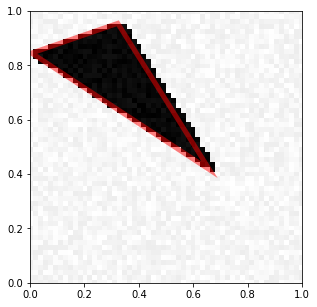

TRAIN PREDICTED:


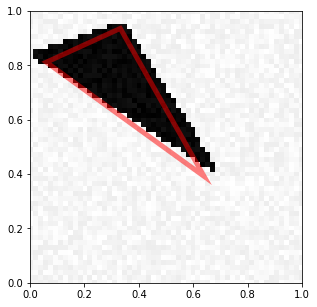

TEST REAL:


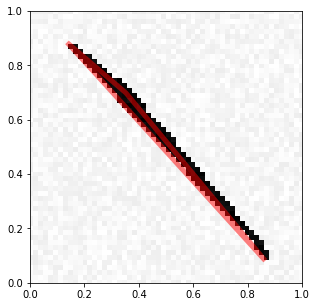

TEST PREDICTED:


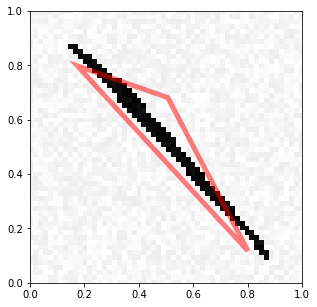

In [11]:
# Test on training data
Y = model3.predict(X_train)
id_ = np.random.randint(0,299)
print("TRAIN REAL:")
visualize_prediction(X_train[id_], Y_train[id_])
print("TRAIN PREDICTED:")
visualize_prediction(X_train[id_], Y[id_]+0.5)

# Test on Testing data
Y_pred = model3.predict(X_test)
id_ = np.random.randint(0,299)
print("TEST REAL:")
visualize_prediction(X_test[id_], Y_test[id_])
print("TEST PREDICTED:")
visualize_prediction(X_test[id_], Y_pred[id_]+0.5)

### Image Denoising
Implement hourglass network denoising:


In [12]:
# New function
def generate_dataset_hourglass(samples, noise=0.0, free_location=False):
    # Getting im_size:
    nsize = generate_a_rectangle().shape[0]
    X = np.zeros([samples,nsize])
    Y = np.zeros(samples)
    for i in range(samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
    noise = np.random.randint(20,50)*np.random.random(X[0].size)
    Y = (X.copy() + noise) / (255 + 2 * noise)
    X = X/255
    return [Y, X]

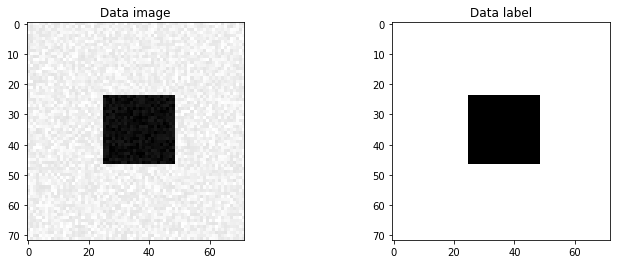

In [13]:
# Plotting data
[X_train, Y_train] = generate_dataset_hourglass(300)
[X_test, Y_test] = generate_dataset_hourglass(300)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
id_ = np.random.randint(X_train.shape[0])
plt.imshow(X_train[id_].reshape(72,72), cmap='gray')
plt.title('Data image')
plt.subplot(1,2,2)
plt.imshow(Y_train[id_].reshape(72,72), cmap='gray')
plt.title('Data label')
plt.show()
